# Telecom Churn Case Study

In [223]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import re
import random

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [224]:
# Print python, jupyter and all the imported library versions
import sys
import jupyter_core
import matplotlib as mpt

print("python : {0}".format(sys.version))
print("jupyter : {0}".format(jupyter_core.__version__))
print("numpy : {0}".format(np.__version__))
print("pandas : {0}".format(pd.__version__))
print("matplotlib : {0}".format(mpt.__version__))
print("seaborn : {0}".format(sns.__version__))

python : 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
jupyter : 5.5.0
numpy : 1.26.4
pandas : 2.1.4
matplotlib : 3.8.0
seaborn : 0.13.2


# Data Understanding

In [226]:
# Load the training dataset, testing data and data dictionary
train_data = pd.read_csv("datasets/train.csv")
test_data = pd.read_csv("datasets/test.csv")
data_dict = pd.read_csv("others/data_dictionary.csv")

In [227]:
# Print the data dictionary
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [228]:
# Print the shape of training data
train_data.shape

(69999, 172)

In [229]:
# Print all columns in the training dataset
pd.set_option('display.max_info_columns', len(train_data.columns))
pd.set_option('display.max_columns', len(train_data.columns))
pd.set_option('display.max_rows', len(train_data.columns))

In [230]:
train_data.columns.tolist()

['id',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 

In [231]:
# Print the first 5 rows of training data
train_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,NaN,7/8/2014,NaN,NaN,1.0,NaN,NaN,145.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,Na

In [232]:
# Print information of the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

In [233]:
# Describe data within the training data
train_data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

In [234]:
# Drop columns where more than 50% of the rows are empty in training data
threshold = len(train_data) * 0.5
train_data = train_data.dropna(axis = 1, thresh = threshold)
train_data

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.00,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.00,0.00,0.0,0.0,0.0,0.0,0.0,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.00,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/

In [235]:
# Drop rows where more than 50% of the columns are empty in training data
threshold = len(train_data.columns) * 0.5
train_data = train_data.dropna(axis = 0, ignore_index = True, thresh = threshold)
train_data

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.00,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.00,0.00,0.0,0.0,0.0,0.0,0.0,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.00,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/

In [236]:
# Find all the columns where the number of values in the column is singular
# These will not contribute towards model building
single_value_cols = set([col for col in train_data.columns if len(train_data[col].value_counts()) == 1])
print("Columns with only one value =", single_value_cols)
train_data = train_data.drop(single_value_cols, axis = 1)
train_data

Columns with only one value = {'loc_ic_t2o_mou', 'std_ic_t2o_mou_8', 'loc_og_t2o_mou', 'last_date_of_month_8', 'last_date_of_month_6', 'last_date_of_month_7', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_6', 'std_og_t2o_mou', 'circle_id', 'std_og_t2c_mou_8'}


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.00,0.00,0.0,0.0,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.00,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.00,0.00,0.0,0.0,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.00,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.0,0.0,0.00,0.0,1.63,6.99,3.94,0.00,37.91,44.89,23.63,0.00,0.00,0.00,0.00,0.00,8.03,44.91,48.84,23.63,0.26,12.06,0.00,15.33,25.93,4.60,0.56,0.0,0.0,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,24.98,4.84,23.88,53.99,44

In [237]:
# Remove columns for T2T, T2M etc for minutes of usage as the total value is part of other columns and will be more relevant
operator_mobile = [col for col in list(train_data.columns) if re.search('t2t_mou', col)]
operator_fixed = [col for col in list(train_data.columns) if re.search('t2f_mou', col)]
operator_call_center = [col for col in list(train_data.columns) if re.search('t2c_mou', col)]
operator_other_mobile = [col for col in list(train_data.columns) if re.search('t2m_mou', col)]
operator_other_fixed = [col for col in list(train_data.columns) if re.search('t2o_mou', col)]
roaming = [col for col in list(train_data.columns) if re.search('roam', col)]

removal_columns = [*operator_mobile, *operator_fixed, *operator_call_center, *operator_other_mobile, *operator_other_fixed, *roaming]
train_data = train_data.drop(removal_columns, axis = 1)
train_data

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [238]:
# Fill data as 0.0 for customers which have churned and the value is not present in the training dataset
# Also, for customers which have not churned but the ARPU (Avg revenue per user) is less than 0 for the same month
def fill_data_for_churned_customers(column, suffix):
    column = column + suffix
    filtered_data = train_data[train_data[column].isna()]
    
    churn_filtered_data = filtered_data[filtered_data.churn_probability == 1]
    train_data.loc[churn_filtered_data.index, column] = 0

    churn_filtered_data = filtered_data[(filtered_data.churn_probability == 0) & (filtered_data['arpu' + suffix] <= 0)]
    train_data.loc[churn_filtered_data.index, column] = 0
    
impute_columns = ['onnet_mou', 'offnet_mou', 'loc_og_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 
                  'loc_ic_mou', 'std_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others']

for column in impute_columns:
    fill_data_for_churned_customers(column, '_6')
    fill_data_for_churned_customers(column, '_7')
    fill_data_for_churned_customers(column, '_8')

train_data

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [239]:
# Fill data as 0.0 for outgoing/incoming call types where customers have total outgoing/incoming calls as 0 in the training dataset
def fill_data_for_og_ic_calls(column, total, suffix):
    column = column + suffix
    total = total + suffix
    filtered_data = train_data[train_data[column].isna()]
    
    total_filtered_data = filtered_data[filtered_data[total] == 0]
    train_data.loc[total_filtered_data.index, column] = 0
    
impute_columns = {
    'loc_og_mou': 'total_og_mou',
    'std_og_mou': 'total_og_mou',
    'isd_og_mou': 'total_og_mou',
    'spl_og_mou': 'total_og_mou',
    'og_others': 'total_og_mou',
    'loc_ic_mou': 'total_ic_mou',
    'std_ic_mou': 'total_ic_mou',
    'isd_ic_mou': 'total_ic_mou',
    'spl_ic_mou': 'total_ic_mou',
    'ic_others': 'total_ic_mou'
}

for column in impute_columns:
    fill_data_for_og_ic_calls(column, impute_columns[column], '_6')
    fill_data_for_og_ic_calls(column, impute_columns[column], '_7')
    fill_data_for_og_ic_calls(column, impute_columns[column], '_8')

train_data

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [240]:
# Fill data as 0.0 for network call types where customers have total calls as 0 in the training dataset
def fill_data_for_net_calls(column, suffix):
    column = column + suffix
    filtered_data = train_data[train_data[column].isna()]
    
    total_filtered_data = filtered_data[(filtered_data['total_og_mou' + suffix] + filtered_data['total_ic_mou' + suffix]) == 0]
    train_data.loc[total_filtered_data.index, column] = 0

for column in ['onnet_mou', 'offnet_mou']:
    fill_data_for_net_calls(column, '_6')
    fill_data_for_net_calls(column, '_7')
    fill_data_for_net_calls(column, '_8')

train_data

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,4

In [241]:
# Drop id column from the data frame as it's not relevant for analysis
train_data = train_data.drop(["id"], axis = 1)
train_data

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.0,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.0,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69236,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,6/18/2014,7/31/2014,8/31/2014,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,119.34,184.76,224.09,0.00,0.0,0.0,0.13,4.01,0.18,0.00,0.0,0.0,166.21,292.74,280.69,54.64,63.88,51.89,25.59,48.54,83.53,80.24,112.43,136.0

# Data Visualisation (EDA)

In [243]:
# Define a list of colors and palettes, and define function to choose randomly
color_list = ["seagreen", "red", "orange", "blue", "pink", "green", "brown", "darkblue", "purple", "grey"]
palette_list = ["Set1", "Set2", "Set3", "Paired", "muted", "deep", "pastel", "hls", "husl"]
cmap_list = ["Spectral", "Greens", "flare_r"]

random_color = lambda: random.choice(color_list)
random_palette = lambda: random.choice(palette_list)
random_cmap = lambda: random.choice(cmap_list)

In [244]:
# Define a function to draw box plots with the given features and choosing colors randomly
def draw_box_plots(size, data, features):
    fig = plt.figure(figsize = (15, size[0]*5))
    
    for i in range(0, len(features)):
        plt.subplot(size[0], size[1], i+1)
        columns = features[i]["columns"]
        plot = sns.boxplot(data = data.loc[:, columns.keys()], color = random_color())
        plot.set_xticks(list(range(0, len(columns.values()))), columns.values())
        plot.set_xlabel(features[i]["title"])
    
    plt.show()

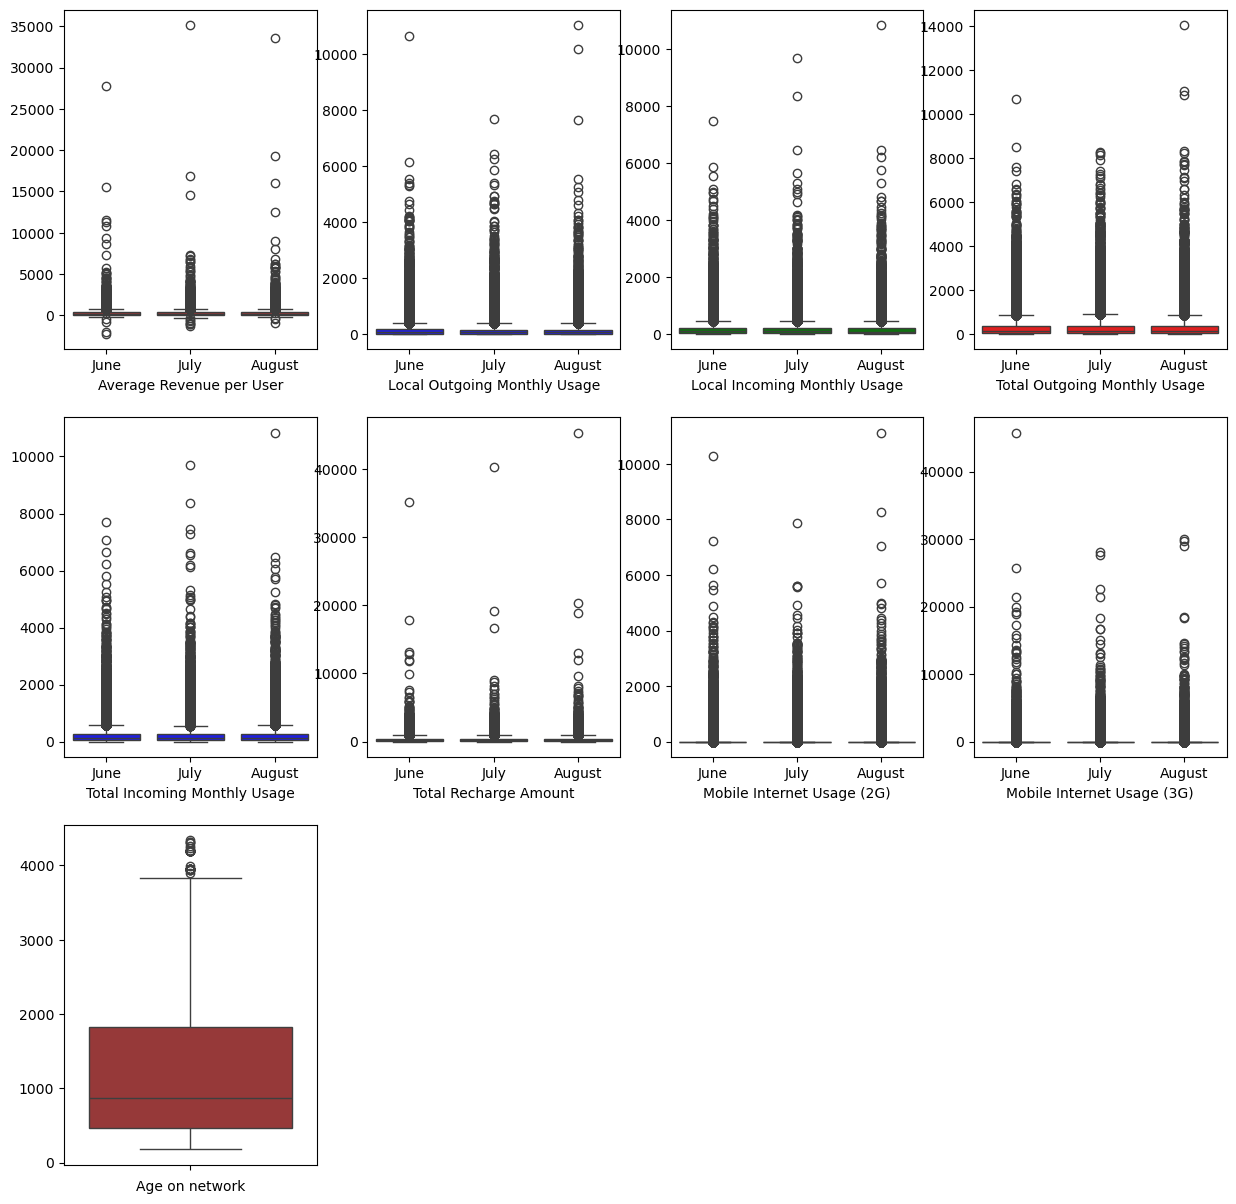

In [245]:
# Draw boxplots for features grouped together for months
features = [
    {
        "columns": { "arpu_6": "June", "arpu_7": "July", "arpu_8": "August" },
        "title": "Average Revenue per User"
    },
    {
        "columns": { "loc_og_mou_6": "June", "loc_og_mou_7": "July", "loc_og_mou_8": "August", },
        "title": "Local Outgoing Monthly Usage"
    },
    {
        "columns": { "loc_ic_mou_6": "June", "loc_ic_mou_7": "July", "loc_ic_mou_8": "August", },
        "title": "Local Incoming Monthly Usage"
    },
    {
        "columns": { "total_og_mou_6": "June", "total_og_mou_7": "July", "total_og_mou_8": "August", },
        "title": "Total Outgoing Monthly Usage"
    },
    {
        "columns": { "total_ic_mou_6": "June", "total_ic_mou_7": "July", "total_ic_mou_8": "August", },
        "title": "Total Incoming Monthly Usage"
    },
    {
        "columns": { "total_rech_amt_6": "June", "total_rech_amt_7": "July", "total_rech_amt_8": "August", },
        "title": "Total Recharge Amount"
    },
    {
        "columns": { "vol_2g_mb_6": "June", "vol_2g_mb_7": "July", "vol_2g_mb_8": "August", },
        "title": "Mobile Internet Usage (2G)"
    },
    {
        "columns": { "vol_3g_mb_6": "June", "vol_3g_mb_7": "July", "vol_3g_mb_8": "August", },
        "title": "Mobile Internet Usage (3G)"
    },
    {
        "columns": { "aon": "" },
        "title": "Age on network"
    }
]
draw_box_plots([3, 4], train_data, features)

In [246]:
# Removing outliers for various columns where data is beyond 97% quantile
remove_outlier = lambda data, column: data[data[column] < data[column].quantile(0.97)]
columns = ["aon", "arpu_8", "loc_og_mou_8", "loc_ic_mou_8", "total_og_mou_8", "total_ic_mou_8", "total_rech_amt_8", "vol_2g_mb_8", 
           "vol_3g_mb_8"]
for column in columns:
    train_data = remove_outlier(train_data, column)

train_data

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.00,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,6/22/2014,7/10/2014,8/24/2014,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,6/12/2014,7/10/2014,8/26/2014,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,6/11/2014,7/22/2014,8/24/2014,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,6/15/2014,7/21/2014,8/25/2014,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,6/25/2014,7/26/2014,8/30/2014,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69235,235.524,195.633,129.598,45.08,94.31,8.34,111.51,236.61,91.54,39.64,101.38,0.00,116.94,229.54,0.00,0.00,0.0,0.0,0.21,1.53,0.00,0.00,0.0,0.0,156.81,332.46,0.00,20.24,54.39,2.38,17.13,108.26,5.16,37.38,173.63,7.55,0.0,0.0,0.00,0.00,10.96,0.00,0.00,0.00,0.00,19,11,11,247,222,143,31,70,50,6/28/2014,7/22/2014,8/29/2014,30,0,50,3.83,0.05,0.00,500.33,124.26,0.00,1,0,0,8,2,0,0,0,0,0,0,0,1507,0.00,16.53,18.84,0
69236,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,

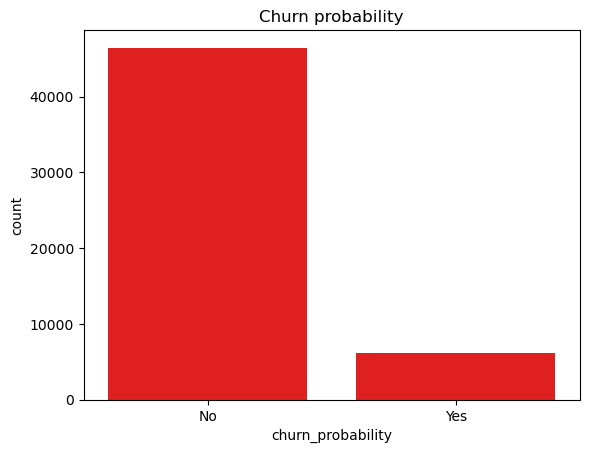

In [247]:
# Plot the key column (churn probability) as count plot
sns.countplot(x=train_data["churn_probability"], color=random_color())
plt.xticks([0, 1], ["No", "Yes"])
plt.title("Churn probability")
plt.show()

In [248]:
# Define a function to draw heatmaps with the given features and choosing colors randomly
def draw_heatmaps(data, features, suffix, title):
    fig = plt.figure(figsize = (len(features), len(features) * 0.75))
    features = [(feat + suffix) for feat in features]
    plot = sns.heatmap(data = data.loc[:, features].corr(), cmap = random_cmap(), annot = True)
    plt.title(title)
    plt.show()

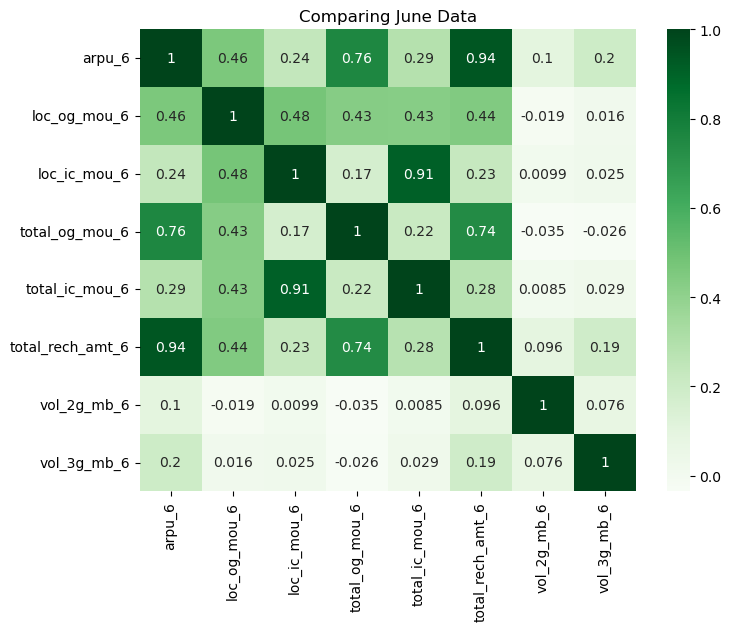

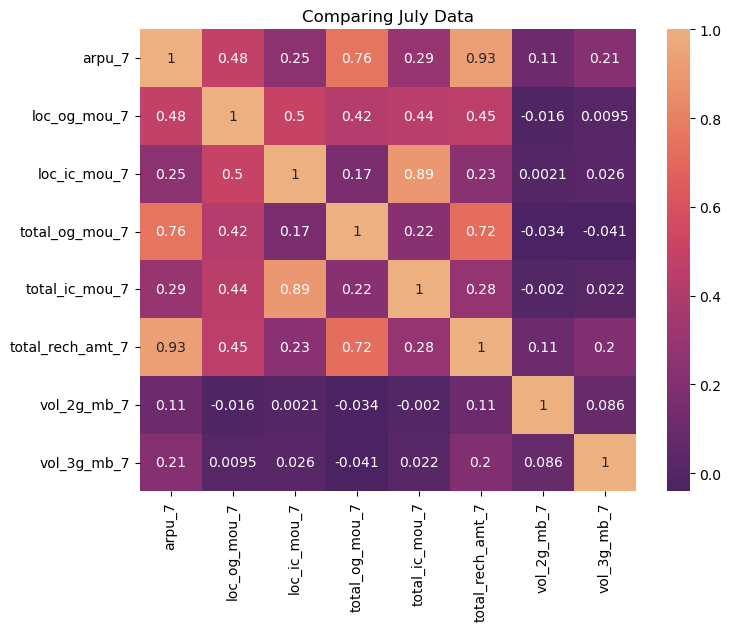

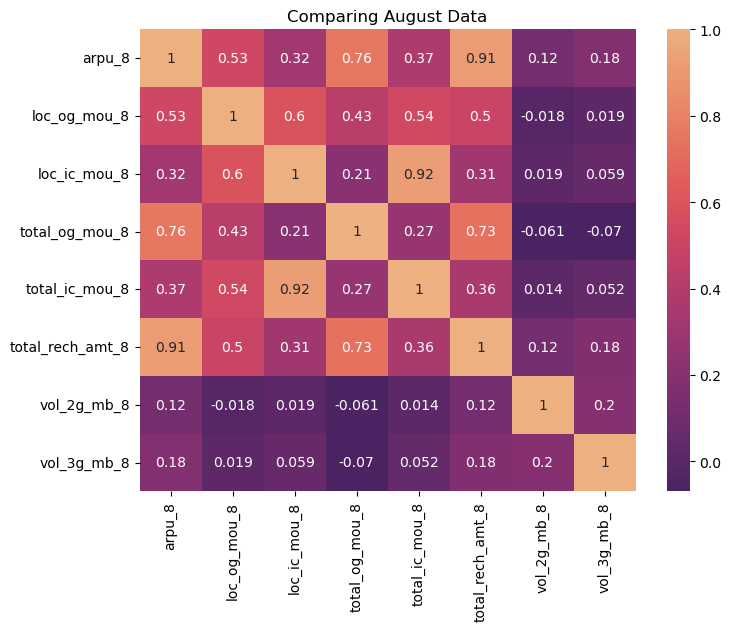

In [249]:
# Draw heatmaps comparing columns for each month separately
columns = ["arpu", "loc_og_mou", "loc_ic_mou", "total_og_mou", "total_ic_mou", "total_rech_amt", "vol_2g_mb", "vol_3g_mb"]
months = {
    "_6": "June",
    "_7": "July",
    "_8": "August"
}

for month in months:
    draw_heatmaps(train_data, columns, month, "Comparing " + months[month] + " Data")

In [250]:
# Define a function to draw a pair plot with the given features and choosing colors randomly
def draw_pair_plot(data, features, title):
    plot = sns.pairplot(data, vars=features.keys(), diag_kws={"color": random_color()}, plot_kws={"color": random_color()})
    plot.x_vars = features.values()
    plot.y_vars = features.values()
    plot._add_axis_labels()
    plot.fig.suptitle(title, y=1.03, size=20)

    plt.show()

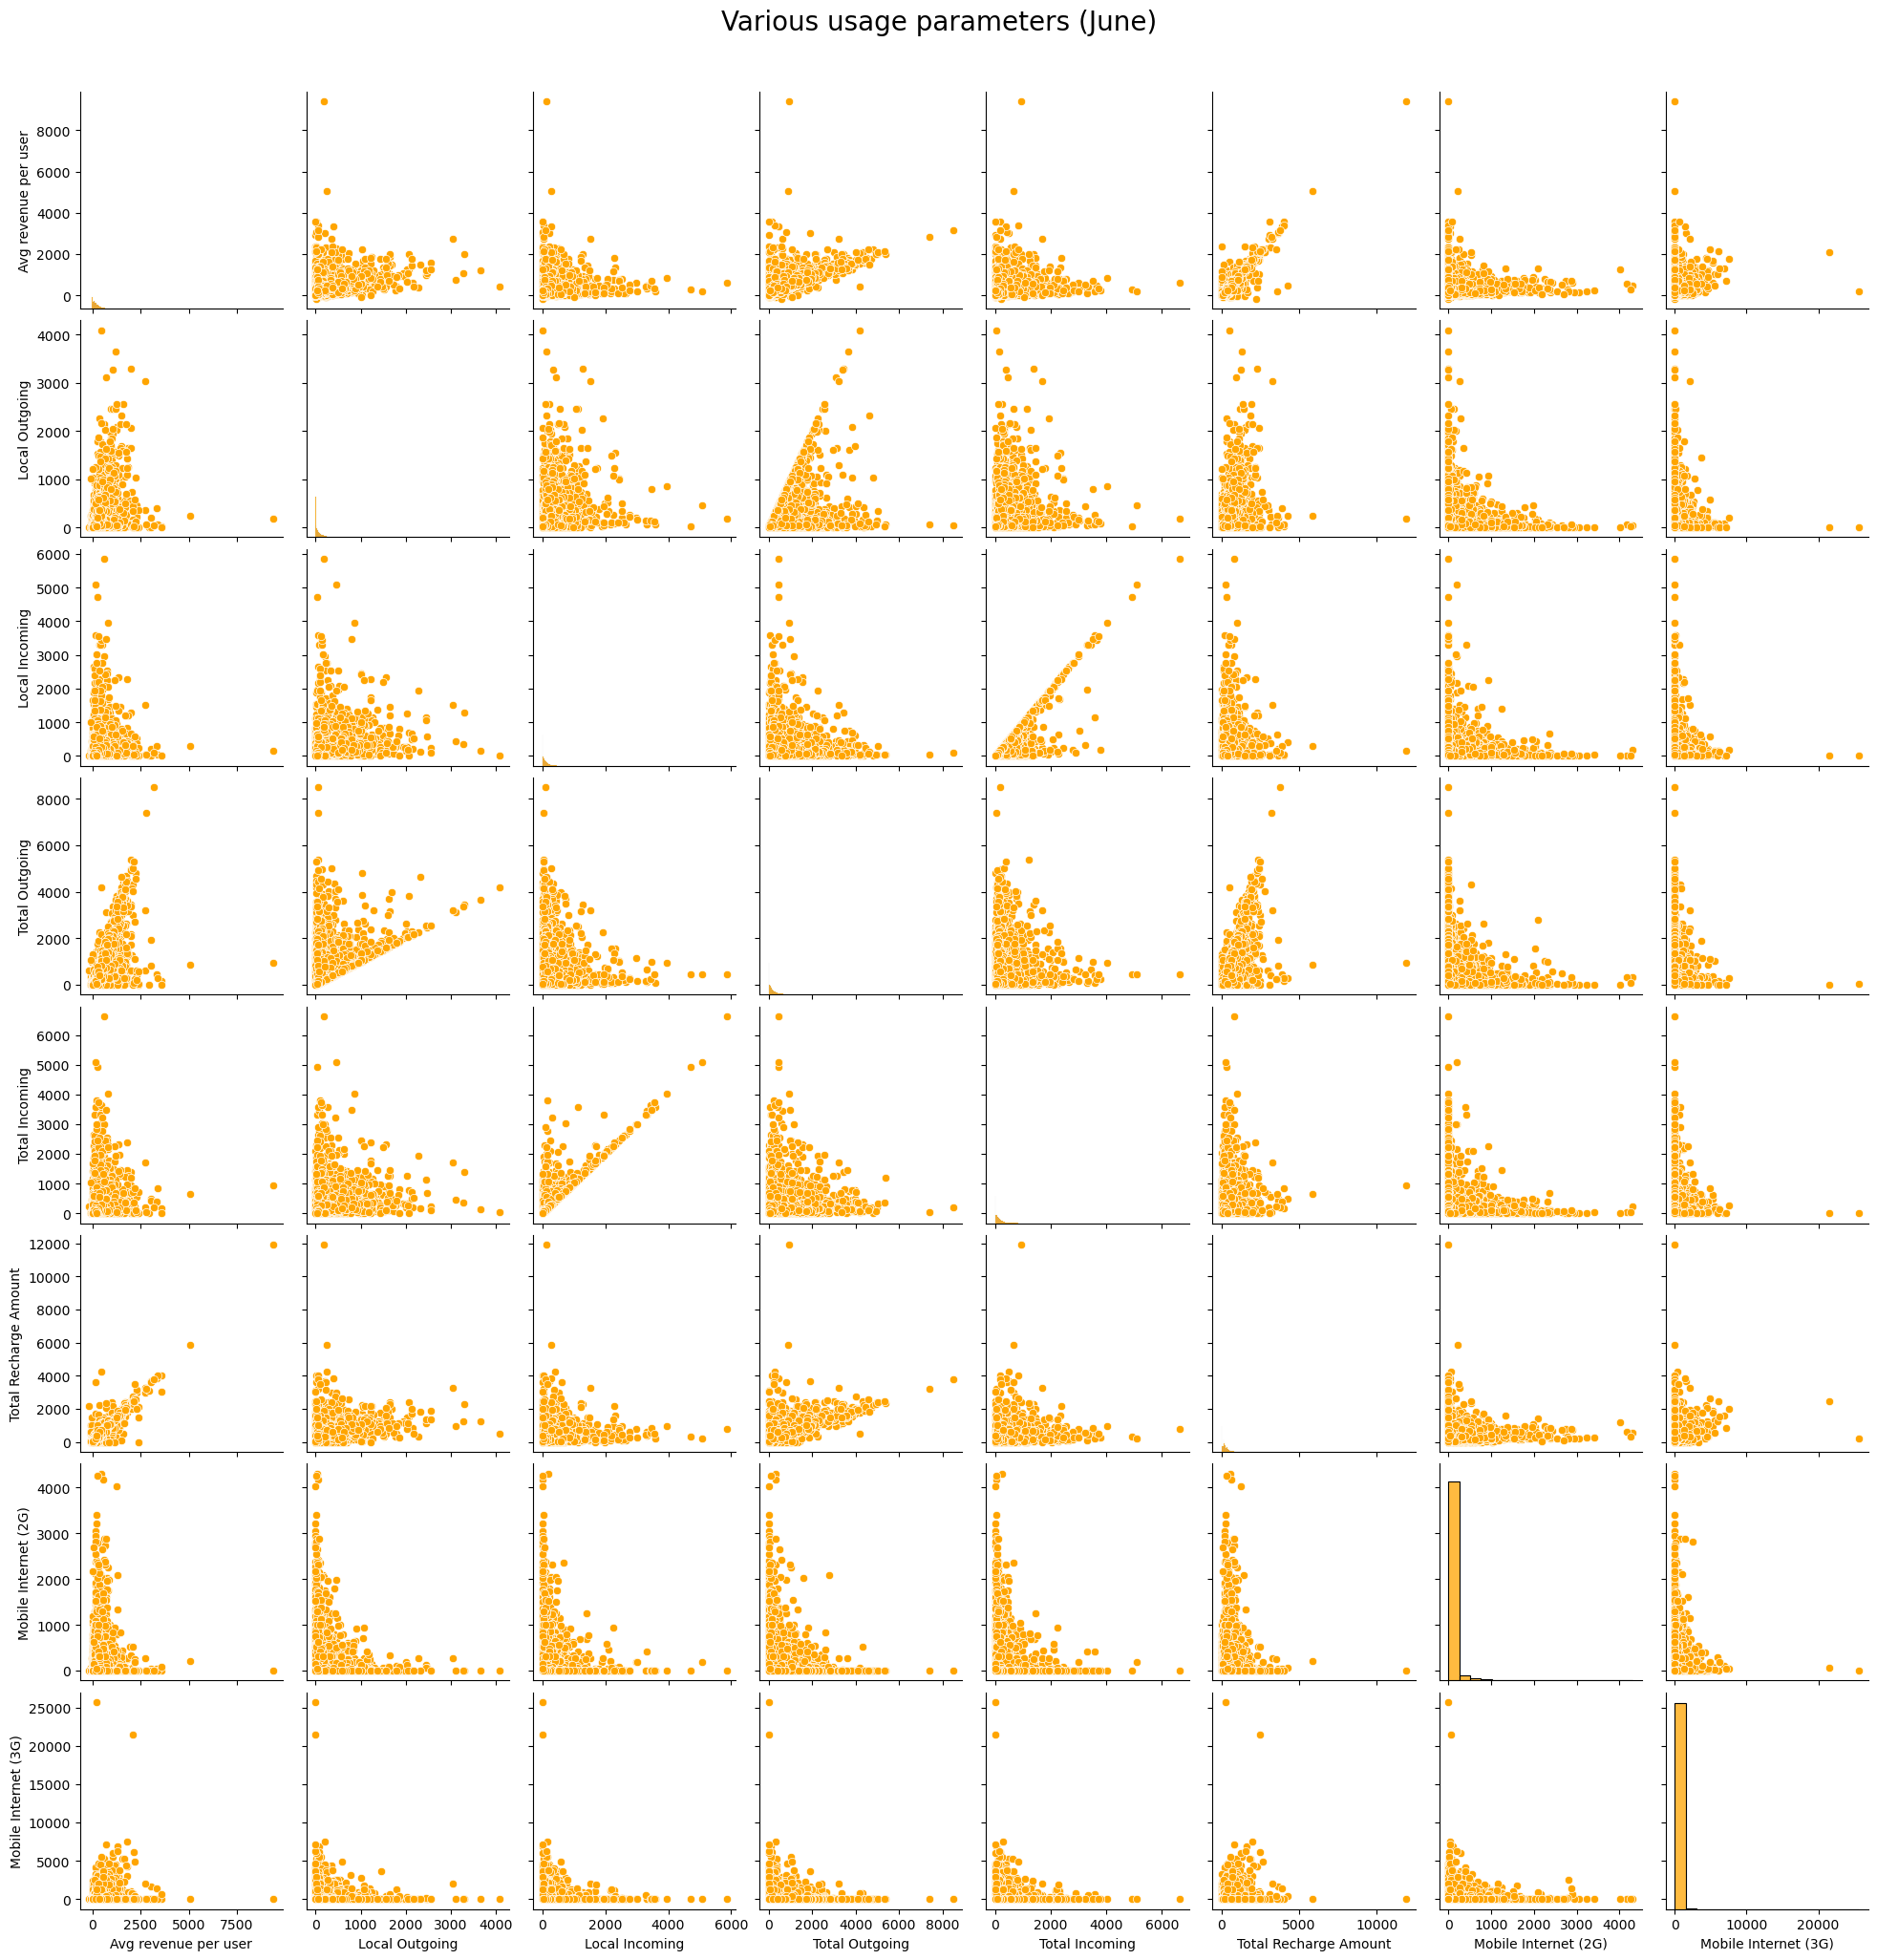

In [251]:
# Pair plot for cnt against calendar parameters like year, weekday etc
features = {
    "arpu_6": "Avg revenue per user", 
    "loc_og_mou_6": "Local Outgoing", 
    "loc_ic_mou_6": "Local Incoming", 
    "total_og_mou_6": "Total Outgoing", 
    "total_ic_mou_6": "Total Incoming", 
    "total_rech_amt_6": "Total Recharge Amount", 
    "vol_2g_mb_6": "Mobile Internet (2G)", 
    "vol_3g_mb_6": "Mobile Internet (3G)"
}

draw_pair_plot(train_data, features, "Various usage parameters (June)")

# Data Preparation

In [253]:
# Remove non-numeric columns from training data
final_train_data = train_data.drop(["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"], axis=1)
final_train_data

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.00,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.00,0.00,0.00,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.00,352.91,0.00,0.00,3.96,0.00,0,0,0,0,0,0,0,1,0,0,0,0,710,0.00,0.00,0.00,0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.00,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,882,0.00,0.00,0.00,0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.00,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,110,110,50,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,982,0.00,0.00,0.00,0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.00,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,25,10,30,390.80,308.89,213.47,0.00,0.00,0.00,0,0,0,7,6,6,0,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69235,235.524,195.633,129.598,45.08,94.31,8.34,111.51,236.61,91.54,39.64,101.38,0.00,116.94,229.54,0.00,0.00,0.0,0.0,0.21,1.53,0.00,0.00,0.0,0.0,156.81,332.46,0.00,20.24,54.39,2.38,17.13,108.26,5.16,37.38,173.63,7.55,0.0,0.0,0.00,0.00,10.96,0.00,0.00,0.00,0.00,19,11,11,247,222,143,31,70,50,30,0,50,3.83,0.05,0.00,500.33,124.26,0.00,1,0,0,8,2,0,0,0,0,0,0,0,1507,0.00,16.53,18.84,0
69236,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,0.00,63.09,96.86,0.00,419.53,293.88,0.00,0.0,0.0,0.00,14.05,1.83,0.00,0.0,0.0,0.00,496.68,392.58,0.00,199.99,257.76,0.00,21.99,11.79,0.00,221.99,269.56,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,17,13,50,397,512,50,110,130,50,20,130,0.00,244.59,144.31,0.00,0.00,0.00,0,0,0,0,6,1,0,0,0,0,1,0,221,0.00,0.00,0.00,0
69237,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,46.73,103.96,56.41,11

In [254]:
# Separate data into feature and target set
y_train_data = final_train_data.pop("churn_probability")
X_train_data = final_train_data

# Print top 5 records from feature training set
X_train_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,7.53,16.04,2.61,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,3.26,24.76,24.71,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.0,0.0,0.0
1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,3.44,39.44,25.03,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.0,352.91,0.00,0.0,3.96,0.0,0,0,0,0,0,0,0,1,0,0,0,0,710,0.0,0.0,0.0
2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,24.64,12.98,0.00,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,94.38,31.34,30.01,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,882,0.0,0.0,0.0
3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,44.91,48.84,23.63,16.16,37.99,4.60,0.0,0.0,0.0,14.95,9.13,25.61,0.00,0.0,0.0,76.03,95.98,53.84,86.21,49.89,81.03,8.89,0.28,2.81,95.11,50.18,83.84,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,2,4,3,160,240,130,110,110,50,110,110,50,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,982,0.0,0.0,0.0
4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,58.91,25.94,15.76,4.35,0.00,0.00,0.0,0.0,0.0,0.00,17.00,0.00,0.00,0.0,0.0,63.26,42.94,15.76,21.54,9.36,28.31,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,13,10,8,290,136,122,50,41,30,25,10,30,390.8,308.89,213.47,0.0,0.00,0.0,0,0,0,7,6,6,0,0,0,0,1,0,647,0.0,0.0,0.0


In [255]:
# Rescale all features using Standard Scaler, use columns which are numeric
scaler = StandardScaler()
X_train_data[X_train_data.columns] = scaler.fit_transform(X_train_data[X_train_data.columns])

# Print first 5 rows of training set
X_train_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,-0.884428,-0.615241,-1.167919,-0.230116,0.177432,-0.527194,-0.502549,-0.200537,-0.761322,-0.620374,-0.591230,-0.773672,-0.230476,0.285632,-0.508534,-0.048441,-0.047591,-0.049751,0.324899,-0.173084,-0.279994,-0.011191,-0.011666,-0.012097,-0.459760,-0.005564,-0.831617,-0.717930,-0.650105,-0.730337,-0.235042,0.067508,-0.105963,-0.731308,-0.556936,-0.713412,-0.417344,-0.278637,4.561270,-0.142657,-0.142453,-0.181683,0.117058,0.021533,-0.115817,-0.626829,-0.826120,-0.745089,-0.689405,-0.726120,-1.109047,-0.258062,-0.224302,-0.929853,0.152821,0.251647,-0.700907,-0.225277,-0.223073,-0.269440,-0.203407,-0.22668,-0.274944,-0.226496,-0.22486,-0.207789,-0.252661,-0.257798,-0.263426,-0.168432,-0.162871,-0.161599,-0.131072,-0.129776,-0.134571,0.937367,-0.245971,-0.226798,-0.212998
1,-1.027630,-0.429212,-0.934263,-0.446054,-0.464608,-0.536348,-0.637426,-0.534372,-0.578453,-0.670324,-0.714840,-0.798615,-0.436928,-0.456061,-0.513516,-0.048441,-0.047591,-0.049751,-0.240980,1.249525,1.975727,-0.106712,-0.011666,-0.012097,-0.690428,-0.624702,-0.707726,-0.716850,-0.544118,-0.727393,-0.339682,-0.369222,-0.465072,-0.775109,-0.641007,-0.840228,-0.417344,-0.278637,-0.227448,-0.142657,-0.142453,-0.181683,-0.114107,-0.115486,-0.115817,-0.626829,-0.495858,-0.216849,-0.980609,-0.387352,-0.888683,-0.982771,0.663602,-0.416128,-0.724463,-0.676893,-0.700907,-0.225277,2.494977,-0.269440,-0.203407,-0.21141,-0.274944,-0.226496,-0.22486,-0.207789,-0.252661,-0.257798,-0.263426,-0.168432,4.451163,-0.161599,-0.131072,-0.129776,-0.134571,-0.498932,-0.245971,-0.226798,-0.212998
2,-0.749230,-0.531180,-1.217565,-0.443698,-0.382378,-0.536348,-0.411556,-0.269628,-0.776241,-0.506875,-0.614811,-0.798615,-0.345136,-0.148551,-0.513516,-0.048441,-0.047591,-0.049751,-0.041542,-0.137637,-0.279994,-0.106712,-0.011666,-0.012097,-0.529974,-0.402176,-0.847662,-0.171087,-0.602598,-0.681579,0.079861,-0.329952,-0.314142,-0.144959,-0.675686,-0.745443,-0.417344,-0.278637,-0.301120,-0.142657,-0.142453,-0.181683,-0.114107,-0.115486,-0.062107,-0.781728,-0.495858,-0.745089,-0.715878,-0.493217,-1.164138,-0.202315,-0.168808,-1.058284,0.220304,0.037369,-0.700907,-0.225277,-0.223073,-0.269440,-0.203407,-0.22668,-0.274944,-0.226496,-0.22486,-0.207789,-0.252661,-0.257798,-0.263426,-0.168432,-0.162871,-0.161599,-0.131072,-0.129776,-0.134571,-0.300980,-0.245971,-0.226798,-0.212998
3,-0.311726,-0.000389,-0.484825,-0.413783,-0.381965,-0.536348,-0.349766,-0.286487,-0.454619,-0.372415,-0.338462,-0.572788,-0.385672,-0.318606,-0.490823,-0.048441,-0.047591,-0.049751,0.790714,0.228649,1.544675,-0.106712,-0.011666,-0.012097,-0.474473,-0.413135,-0.609692,-0.220118,-0.468670,-0.212210,-0.214984,-0.364789,-0.398597,-0.297113,-0.574616,-0.359765,-0.417344,-0.278637,-0.301120,-0.142657,-0.142453,-0.181683,-0.114107,-0.115486,-0.115817,-0.781728,-0.495858,-0.569009,-0.375509,0.014936,-0.447955,0.243660,0.275144,-0.416128,0.760171,0.894482,0.036280,-0.225277,-0.223073,-0.269440,-0.203407,-0.22668,-0

# Model Building

## Logistic Regression

In [258]:
# Initialize Logistic Regression model, and select features using RFE in a GridSearch
# logistic_model = LogisticRegression()
# logistic_rfe = RFE(logistic_model)
# Parameters to tune: n_features_to_select

params = {
    "n_estimators": [10, 25, 50, 100],
    "n_features_to_select": [10, 15, 20, 25]
}
grid_search_logistic = GridSearchCV(estimator = RFE(LogisticRegression()),
                           param_grid = params,
                           cv = 5,
                           n_jobs = -1,
                           scoring = "accuracy")
grid_search_logistic.fit(X_train_data, y_train_data)

In [ ]:
print("Best Score =", grid_search_logistic.best_score_)
logistic_rfe = grid_search_logistic.best_estimator_
grid_search_logistic.best_estimator_

In [259]:
# Print the wieghtage of each column after RFE
print(list(zip(X_train_data.columns, logistic_rfe.support_, logistic_rfe.ranking_)))

# Store the selected columns
selected_columns = X_train_data.columns[logistic_rfe.support_]

[('arpu_6', True, 1), ('arpu_7', False, 10), ('arpu_8', False, 41), ('onnet_mou_6', False, 6), ('onnet_mou_7', False, 25), ('onnet_mou_8', True, 1), ('offnet_mou_6', False, 4), ('offnet_mou_7', False, 24), ('offnet_mou_8', True, 1), ('loc_og_mou_6', False, 21), ('loc_og_mou_7', False, 26), ('loc_og_mou_8', False, 14), ('std_og_mou_6', False, 20), ('std_og_mou_7', False, 23), ('std_og_mou_8', True, 1), ('isd_og_mou_6', False, 65), ('isd_og_mou_7', False, 48), ('isd_og_mou_8', False, 46), ('spl_og_mou_6', False, 32), ('spl_og_mou_7', False, 22), ('spl_og_mou_8', False, 15), ('og_others_6', False, 51), ('og_others_7', False, 64), ('og_others_8', True, 1), ('total_og_mou_6', False, 5), ('total_og_mou_7', False, 47), ('total_og_mou_8', True, 1), ('loc_ic_mou_6', False, 43), ('loc_ic_mou_7', False, 3), ('loc_ic_mou_8', True, 1), ('std_ic_mou_6', False, 27), ('std_ic_mou_7', False, 57), ('std_ic_mou_8', False, 13), ('total_ic_mou_6', False, 9), ('total_ic_mou_7', False, 44), ('total_ic_mou_8'

In [260]:
# Train the logistic model using the columns obtained from RFE, print the summary
X_train_data_selected = sm.add_constant(X_train_data[selected_columns])
logistic_model = sm.GLM(y_train_data, X_train_data_selected)
logistic_result = logistic_model.fit()
logistic_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      churn_probability   No. Observations:                52636
Model:                            GLM   Df Residuals:                    52620
Model Family:                Gaussian   Df Model:                           15
Link Function:               Identity   Scale:                        0.082995
Method:                          IRLS   Log-Likelihood:                -9174.3
Date:                Sat, 07 Dec 2024   Deviance:                       4367.2
Time:                        10:33:16   Pearson chi2:                 4.37e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2187
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1172      0.001     93.321      0.000       0.115       0.120
arpu_6                 0.0571      0.001     42.958      0.000       0.055       0.060
onnet_mou_8            0.1241      0.006     20.619      0.000       0.112       0.136
offnet_mou_8           0.1421      0.007     21.451      0.000       0.129       0.155
std_og_mou_8           0.0191      0.004      5.424      0.000       0.012       0.026
og_others_8            0.0022      0.001      1.786      0.074      -0.000       0.005
total_og_mou_8        -0.2416      0.009    -25.508      0.000      -0.260      -0.223
loc_ic_mou_8          -0.0193      0.003     -5.618      0.000      -0.026      -0.013
total_ic_mou_8        -0.0406      0.003    -12.349      0.000      -0.047      -0.034
spl_ic_mou_8          -0.0281      0.001    -21.813      0.000      -0.031      -0.026
total_rech_num_8      -0.0431      0.002    -22.152      0.000      -0.047      -0.039
total_rech_amt_8      -0.0058      0.003     -1.821      0.069      -0.012       0.000
max_rech_amt_8        -0.0349      0.002    -15.820      0.000      -0.039      -0.031
last_day_rch_amt_8    -0.0216      0.002    -12.415      0.000      -0.025      -0.018
vol_3g_mb_8           -0.0153      0.001    -11.189      0.000      -0.018      -0.013
aon                   -0.0277      0.001    -20.550      0.000      -0.030      -0.025
======================================================================================
"""

In [261]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = logistic_result.predict(X_train_data_selected)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'churn_probability': y_train_data_pred })
y_train_data_pred['id'] = y_train_data.index
y_train_data_pred['prediction'] = y_train_data_pred.churn_probability.map(lambda prob: 1 if prob > 0.5 else 0)
y_train_data_pred

,churn,churn_probability,id,prediction
0,0,0.063666,0,0
1,0,0.187663,1,0
2,0,0.247914,2,0
3,0,0.183547,3,0
4,0,0.230402,4,0
...,...,...,...,...
69235,0,0.267691,69235,0
69236,0,-0.094937,69236,0
69237,0,0.012698,69237,0
69238,0,-0.119939,69238,0


In [262]:
# Print confusion matrix, accuracy and other scores
print("Confusion Matrix = \n", metrics.confusion_matrix(y_train_data_pred.churn, y_train_data_pred.prediction))
print("Accuracy score =", round(metrics.accuracy_score(y_train_data_pred.churn, y_train_data_pred.prediction), 2))
print("Precision score = ", round(metrics.precision_score(y_train_data_pred.churn, y_train_data_pred.prediction), 2))
print("Recall score = ", round(metrics.recall_score(y_train_data_pred.churn, y_train_data_pred.prediction), 2))

Confusion Matrix = 
 [[46311   157]
 [ 5911   257]]
Accuracy score = 0.88
Precision score =  0.62
Recall score =  0.04


## Random Forest

In [ ]:
# Create random forest and fit data into it
random_forest = RandomForestClassifier()
params = {
    "n_estimators": [10, 25, 50, 100],
    "max_depth": [3, 7, 10, 15],
    "max_features": [5, 10, 15, 20],
    "min_samples_leaf": [10, 20, 50, 100]
}
# n_estimators=25, max_depth=10, max_features=15
grid_search = GridSearchCV(estimator = random_forest,
                           param_grid = params,
                           cv = 5,
                           n_jobs = -1,
                           scoring = "accuracy")
grid_search.fit(X_train_data, y_train_data)

In [205]:
print("Best Score =", grid_search.best_score_)
grid_search.best_estimator_

RandomForestClassifier(max_depth=5, max_features=10, n_estimators=25)

In [203]:
grid_search.best_score_

0.9328406160248521

In [156]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_train_data_pred = forest_result.predict(X_train_data)
y_train_data_pred = pd.DataFrame({ 'churn': y_train_data.values, 'churn_probability': y_train_data_pred })
y_train_data_pred['id'] = y_train_data.index
y_train_data_pred['prediction'] = y_train_data_pred.churn_probability.map(lambda prob: 1 if prob > 0.5 else 0)
y_train_data_pred

,churn,churn_probability,id,prediction
0,0,0,0,0
1,0,0,1,0
2,0,0,2,0
3,0,0,3,0
4,0,0,4,0
...,...,...,...,...
52631,0,0,69235,0
52632,0,0,69236,0
52633,0,0,69237,0
52634,0,0,69238,0


In [157]:
# Print confusion matrix, accuracy and other scores
print("Confusion Matrix = \n", metrics.confusion_matrix(y_train_data_pred.churn, y_train_data_pred.prediction))
print("Accuracy score =", round(metrics.accuracy_score(y_train_data_pred.churn, y_train_data_pred.prediction), 2))
print("Precision score = ", round(metrics.precision_score(y_train_data_pred.churn, y_train_data_pred.prediction), 2))
print("Recall score = ", round(metrics.recall_score(y_train_data_pred.churn, y_train_data_pred.prediction), 2))

Confusion Matrix = 
 [[45532   936]
 [ 2000  4168]]
Accuracy score = 0.94
Precision score =  0.82
Recall score =  0.68


## XGBoost Regressor

## PCA + Logistic Regression

## PCA + Random Forest

## PCA + XGBoost Regressor

# Model Selection

In [207]:
final_model = grid_search.best_estimator_

# Evaluation and Prediction

In [209]:
test_data = test_data.fillna(0)
test_data

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,0.00,0.00,0.00,0.00,0.00,0.00,24.88,20.23,21.06,18.13,10.89,8.36,0.00,13.58,0.00,0.00,0.00,0.03,43.01,44.71,29.43,6.90,0.00,2.05,42.03,7.68,26.43,0.0,0.00,0.0,0.0,0.0,0.0,48.93,7.68,28.48,0.00,0.00,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,30.33,37.56,21.98,10.21,4.59,9.53,0.26,0.00,0.00,40.81,42.16,31.51,0.00,0.00,0.00,0.36,1.04,4.34,0.00,0.00,0.00,0.0,0.0,0.0,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.00,0.00,5,5,4,103,90,60,50,30,30,6/21/2014,7/26/2014,8/24/2014,30,30,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,0.00,0.00,0.00,0.00,0.00,0.00,75.51,41.21,19.84,473.61,598.08,377.26,0.73,0.00,0.00,0.00,0.00,0.00,549.86,639.29,397.11,0.00,0.00,0.00,0.00,23.76,17.68,0.0,0.00,0.0,0.0,0.0,0.0,0.00,23.76,17.68,0.00,0.00,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,19.99,26.95,2.61,160.19,122.29,184.81,1.49,0.00,0.00,181.69,149.24,187.43,0.00,0.00,0.00,0.00,12.51,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.00,0.00,5,4,5,500,500,500,250,250,250,6/19/2014,7/16/2014,8/24/2014

In [211]:
# Create test data as per the final training data columns
X_test_data = test_data.loc[:, final_train_data.columns]

# Print top 5 records from feature testing set
X_test_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,91.882,65.330,64.445,31.78,20.23,23.11,60.16,32.16,34.83,43.01,44.71,29.43,48.93,7.68,28.48,0.0,0.0,0.0,0.00,0.00,0.03,0.0,0.0,0.0,91.94,52.39,57.94,40.81,42.16,31.51,0.36,1.04,4.34,41.73,43.56,36.26,0.54,0.34,0.39,0.00,0.00,0.00,0.0,0.0,0.00,5,5,4,103,90,60,50,30,30,30,30,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1692,0.00,0.00,0.00
1,414.168,515.568,360.868,75.51,41.21,19.84,474.34,621.84,394.94,549.86,639.29,397.11,0.00,23.76,17.68,0.0,0.0,0.8,0.00,0.00,0.00,0.0,0.0,0.0,549.86,663.06,415.59,181.69,149.24,187.43,0.00,12.51,0.00,296.33,339.64,281.66,0.00,0.00,0.00,114.63,177.88,94.23,0.0,0.0,0.00,5,4,5,500,500,500,250,250,250,250,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,2533,0.00,0.00,0.00
2,329.844,434.884,746.239,7.54,7.86,8.40,16.98,45.81,45.04,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,6,9,5,500,1000,1000,300,500,500,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,277,525.61,758.41,241.84
3,43.550,171.390,24.400,5.31,2.16,0.00,40.04,205.01,24.01,8.26,98.61,22.86,37.09,96.53,0.00,0.0,0.0,0.0,0.00,12.03,1.15,0.0,0.0,0.0,45.36,207.18,24.01,546.06,504.86,531.64,9.63,16.14,8.83,555.69,522.44,549.13,0.00,0.00,0.00,0.00,1.43,8.65,0.0,0.0,0.00,3,5,2,110,260,0,110,150,0,110,150,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1244,0.00,0.00,0.00
4,306.854,406.289,413.329,450.93,609.03,700.68,60.94,23.84,74.16,2.84,3.44,25.51,509.03,629.43,749.29,0.0,0.0,0.0,0.71,5.39,4.96,2.2,0.0,0.0,514.79,638.28,779.78,10.13,9.59,17.61,43.59,106.33,141.48,53.73,115.93,159.26,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.16,11,7,8,356,490,546,90,130,130,50,130,130,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,462,0.00,0.00,0.00


In [213]:
# Scale test data using earlier fitted scaler
X_test_data[X_test_data.columns] = scaler.transform(X_test_data[X_test_data.columns])

# Print first 5 rows of training set
X_test_data.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,-0.606948,-0.727962,-0.792510,-0.304792,-0.360182,-0.372356,-0.385744,-0.505234,-0.553225,-0.385018,-0.370289,-0.517359,-0.281732,-0.428273,-0.373015,-0.048441,-0.047591,-0.049751,-0.240980,-0.202860,-0.277856,-0.106712,-0.011666,-0.012097,-0.429282,-0.554472,-0.591570,-0.492579,-0.524480,-0.667779,-0.334633,-0.352754,-0.362402,-0.575453,-0.615538,-0.748548,3.261478,2.387231,2.57211,-0.142657,-0.142453,-0.181683,-0.114107,-0.115486,-0.115817,-0.317031,-0.330727,-0.392929,-0.591076,-0.620255,-0.833592,-0.425302,-0.612760,-0.672991,-0.319563,-0.248336,-0.700907,-0.225277,-0.223073,-0.26944,-0.203407,-0.22668,-0.274944,-0.226496,-0.22486,-0.207789,-0.252661,-0.257798,-0.263426,-0.168432,-0.162871,-0.161599,-0.131072,-0.129776,-0.134571,0.631233,-0.245971,-0.226798,-0.212998
1,0.868641,1.613073,1.162580,-0.110413,-0.251885,-0.395561,1.346996,2.279538,1.752554,2.977158,4.211752,2.996470,-0.436928,-0.370093,-0.426295,-0.048441,-0.047591,0.181729,-0.240980,-0.202860,-0.279994,-0.106712,-0.011666,-0.012097,0.871390,1.425573,0.989222,0.352891,0.248623,0.766640,-0.339682,-0.171126,-0.465072,0.752111,1.214727,1.256648,-0.417344,-0.278637,-0.30112,3.599526,5.628297,4.672630,-0.114107,-0.115486,-0.115817,-0.317031,-0.495858,-0.216849,0.910330,1.115934,1.590412,1.804571,1.828975,2.152496,2.649706,-0.676893,-0.700907,-0.225277,-0.223073,-0.26944,-0.203407,-0.22668,-0.274944,-0.226496,-0.22486,-0.207789,-0.252661,-0.257798,-0.263426,-0.168432,-0.162871,-0.161599,-0.131072,-0.129776,-0.134571,1.599124,-0.245971,-0.226798,-0.212998
2,0.482563,1.193552,3.704336,-0.412538,-0.424035,-0.476740,-0.566389,-0.440772,-0.487851,-0.670324,-0.714840,-0.798615,-0.436928,-0.456061,-0.513516,-0.048441,-0.047591,-0.049751,-0.240980,-0.202860,-0.279994,-0.106712,-0.011666,-0.012097,-0.690428,-0.724342,-0.847662,-0.737495,-0.828869,-0.957662,-0.339682,-0.369222,-0.465072,-0.793046,-0.884811,-1.044833,-0.417344,-0.278637,-0.30112,-0.142657,-0.142453,-0.181683,-0.114107,-0.115486,-0.115817,-0.162132,0.329798,-0.216849,0.910330,3.233239,4.344961,2.362040,4.603674,5.363276,-0.724463,-0.676893,-0.700907,-0.225277,-0.223073,-0.26944,-0.203407,-0.22668,-0.274944,-0.226496,-0.22486,-0.207789,-0.252661,-0.257798,-0.263426,-0.168432,-0.162871,-0.161599,-0.131072,-0.129776,-0.134571,-0.997263,4.090883,4.726053,1.299145
3,-0.828236,-0.176498,-1.056632,-0.422451,-0.453458,-0.536348,-0.469917,0.311053,-0.622506,-0.615532,0.045083,-0.580147,-0.319286,-0.106797,-0.513516,-0.048441,-0.047591,-0.049751,-0.240980,0.365711,-0.198058,-0.106712,-0.011666,-0.012097,-0.561588,-0.052579,-0.741539,2.539604,2.816148,3.933272,-0.204604,-0.113645,-0.256183,2.104494,2.344734,3.442181,-0.417344,-0.278637,-0.30112,-0.142657,-0.096061,0.263926,-0.114107,-0.115486,-0.115817,-0.626829,-0.330727,-0.745089,-0.564603,0.099628,-1.164138,0.243660,0.719096,-1.058284,0.760171,1.465891,-0.700907,-0.225277,-0.223073,-0.26944,-0.203407,-0.22668,-0.274944,-0.226496,-0.22486,-0.207789,-0.252

In [215]:
# Prepare dataframe containing actual churn and churn prediction obtained from the model
y_test_data_pred = final_model.predict(X_test_data)
y_test_data_pred = pd.DataFrame({ 'churn_probability': y_test_data_pred })
y_test_data_pred['id'] = test_data.id
y_test_data_pred['prediction'] = y_test_data_pred.churn_probability.map(lambda prob: 1 if prob > 0.5 else 0)
y_test_data_pred

,churn_probability,id,prediction
0,0,69999,0
1,0,70000,0
2,1,70001,1
3,0,70002,0
4,0,70003,0
...,...,...,...
29995,0,99994,0
29996,0,99995,0
29997,0,99996,0
29998,0,99997,0


In [219]:
output = y_test_data_pred[['id','churn_probability']]
output.to_csv('results/submission_grid_search_random_forest.csv',index=False)
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0
